# Severe Weather - EDA

Greg Welliver   

In [1]:
# Import relevant libraries and packages.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing 
import warnings
from scipy import stats
import re
from glob import glob, iglob
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS

# Seaborn settings
sns.set_context('notebook')
#sns.set_style("whitegrid")
#sns.set_style("white")
style_set = sns.set_style('whitegrid')
pd.options.display.float_format = '{:,}'.format
color_choice1 = 'plum'
color_choice2 = 'lightblue'
color_choice3 = 'lightgreen'
#ax.yaxis.set_major_formatter('{x:,.0f}')
#sns.set_context('notebook', font_scale = 4)

%matplotlib inline
import pandas as pd
#from mpl_toolkits.basemap import Basemap

import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as ctx

from sklearn.feature_extraction.text import CountVectorizer

## Load the data



In [2]:
# load data
#df = pd.read_csv("../Data/StormEvents_details-ftp_v1.0_d2001_c20220425.csv")
#df = pd.read_parquet("../Data/all_storm_data9.pqt")
df = pd.read_parquet("../Data/all_storm_data11.pqt")
state_population = pd.read_csv("../Data/state_population.csv")

In [3]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
BEGIN_YEARMONTH,202202,202202,202202,202202,202202,202202,202202,202202,202202,202202
BEGIN_TIME,2118,800,200,1609,0,500,100,100,200,400
STATE,NEVADA,NEVADA,NEVADA,ATLANTIC SOUTH,AMERICAN SAMOA,AMERICAN SAMOA,KANSAS,KANSAS,MASSACHUSETTS,MASSACHUSETTS
YEAR,2022,2022,2022,2022,2022,2022,2022,2022,2022,2022
MONTH_NAME,February,February,February,February,February,February,February,February,February,February
EVENT_TYPE,High Wind,Heavy Snow,Heavy Snow,Waterspout,Heavy Rain,Heavy Rain,Winter Storm,Winter Storm,Heavy Snow,Heavy Snow
BEGIN_DATE_TIME,2022-02-20 21:18:00,2022-02-21 08:00:00,2022-02-22 02:00:00,2022-02-18 16:09:00,2022-02-02 00:00:00,2022-02-12 05:00:00,2022-02-01 01:00:00,2022-02-01 01:00:00,2022-02-13 02:00:00,2022-02-13 04:00:00
INJURIES_DIRECT,0,0,0,0,0,0,0,0,0,0
INJURIES_INDIRECT,0,0,0,0,0,0,0,0,0,0
DEATHS_DIRECT,0,0,0,0,0,0,0,0,0,0


In [4]:
len(df)

1555647

### This map shows the density of storms across the US.

''

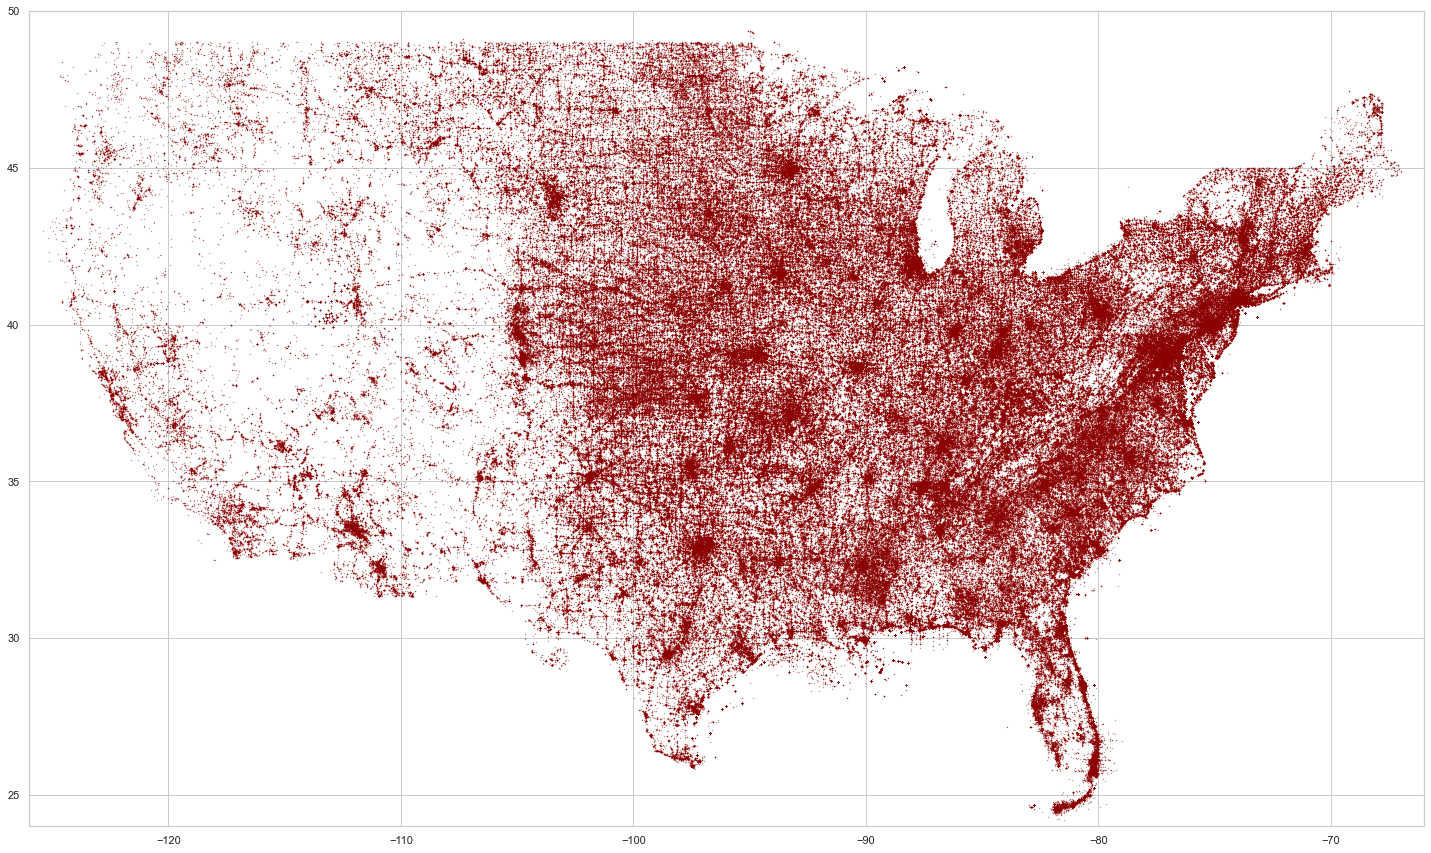

In [5]:
df_map = df[['BEGIN_LAT', 'BEGIN_LON']]
df_map = df_map.dropna()
df_map.head().reset_index().drop(['index'], axis=1)
BBox = ((-126,   -66,      
         24, 50))
fig, ax = plt.subplots(figsize = (25,15))
ax.scatter(df_map.BEGIN_LON, df_map.BEGIN_LAT, zorder=1, alpha= .6, s=.1, c='darkred')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
#plt.rcParams.update({'font.size': 30})
;

### Look at the trend of reported storms over time

''

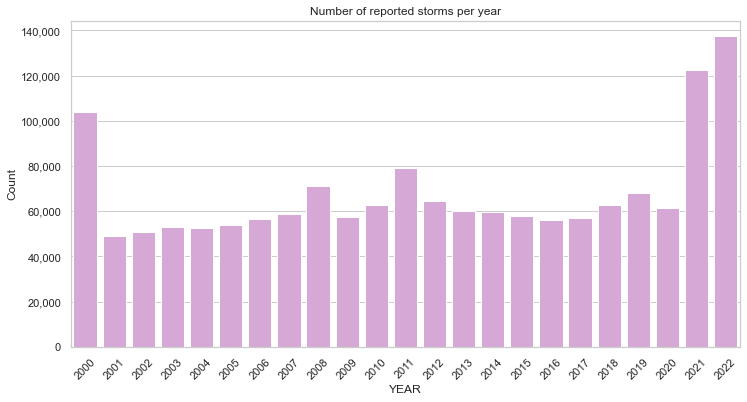

In [6]:
fig, ax = plt.subplots(figsize = (12 , 6))
plt.title("Number of reported storms per year")
sns.countplot(x='YEAR', data=df, color=color_choice1)
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.set_ylabel( "Count" , size = 12 )
;

In [7]:
# the large increase from 2020 to 2021 is worth looking into
len(df[df['YEAR'] == 2021]) - len(df[df['YEAR'] == 2020])

61249

In [8]:
df[df['YEAR'] == 2020].EVENT_TYPE.value_counts()[:10]

Thunderstorm Wind           19314
Hail                         7670
High Wind                    3669
Flash Flood                  3571
Winter Weather               2910
Marine Thunderstorm Wind     2887
Flood                        2703
Drought                      2244
Winter Storm                 2094
Heavy Snow                   1792
Name: EVENT_TYPE, dtype: int64

In [9]:
df[df['YEAR'] == 2021].EVENT_TYPE.value_counts()[:10]

Thunderstorm Wind           31066
Hail                        12544
Flash Flood                  9594
High Wind                    9194
Drought                      8166
Winter Weather               7828
Winter Storm                 5890
Marine Thunderstorm Wind     5368
Heavy Snow                   4468
Flood                        4062
Name: EVENT_TYPE, dtype: int64

#### Comment on the large change from 2020 to 2021:
I was not able to find if there was a change in reporting methodology that drove the large increase year-over-year.  Looking at the storm event data, it does not appear to be isolated to any one particular type of storm - there is an increase across a number of different categories. It seems unlikely that the number of storms actually doubled year-over-year, so will monitor the potential impact of this.

### Let's look at what months of the year storms tend to occur

''

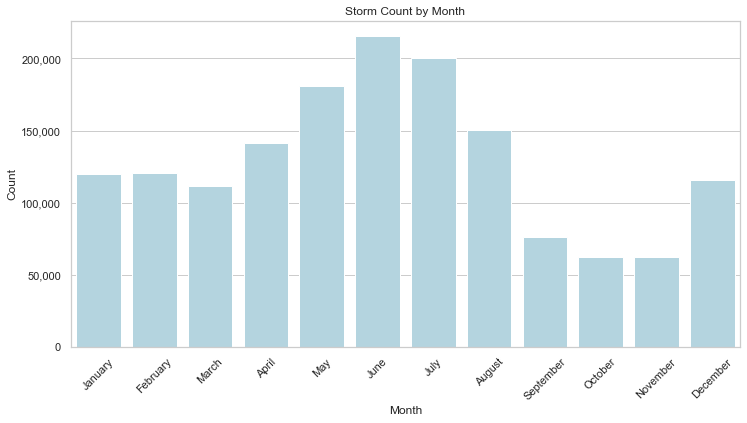

In [10]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
fig, ax = plt.subplots(figsize = (12 , 6))
plt.title("Storm Count by Month")
sns.countplot(x='MONTH_NAME', data=df, color=color_choice2, order=month_order)
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.set_xlabel( "Month" , size = 12 )
ax.set_ylabel( "Count" , size = 12 )
;

### Let's look at storms by state

''

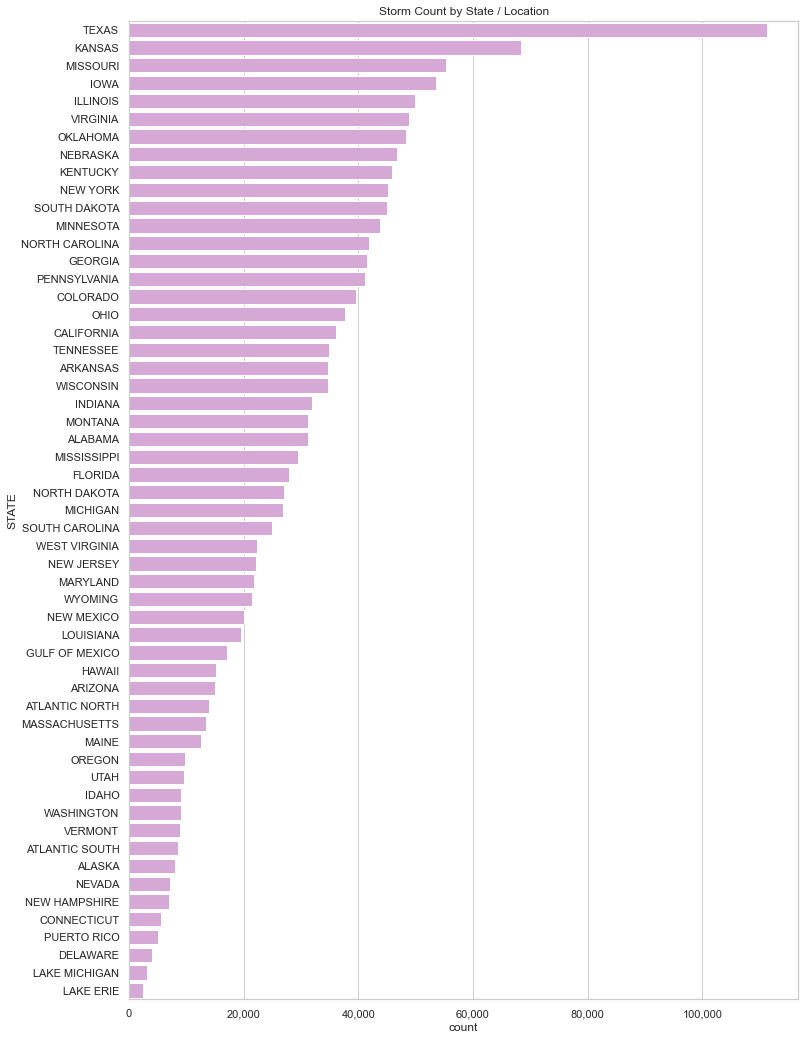

In [11]:
df_state = df[df.groupby('STATE')['STATE'].transform('size') > 2000].reset_index(drop=True)

fig, ax = plt.subplots(figsize = (12 , 18))
plt.title("Storm Count by State / Location")

sns.countplot(y='STATE', data=df_state, color=color_choice1, order=df_state['STATE'].value_counts().index)
ax.xaxis.set_major_formatter('{x:,.0f}')
;

### Let's look at storm counts by type

''

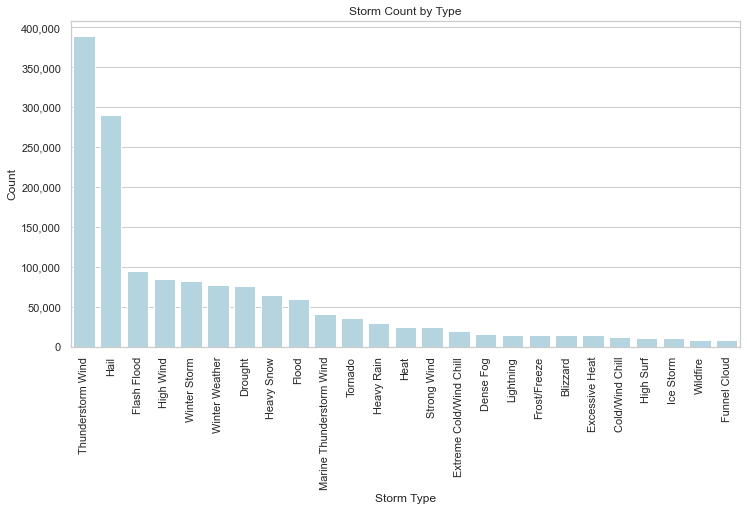

In [12]:
df_events = df[df.groupby('EVENT_TYPE')['EVENT_TYPE'].transform('size') > 7000].reset_index(drop=True)

fig, ax = plt.subplots(figsize = (12 , 6))
plt.title("Storm Count by Type")

sns.countplot(x='EVENT_TYPE', data=df_events, color=color_choice2, order=df_events['EVENT_TYPE'].value_counts().index)
plt.xticks(rotation=90)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.set_xlabel( "Storm Type" , size = 12 )
ax.set_ylabel( "Count" , size = 12 )
;

### Let's take a closer look at our dependent variable, Property Damage ('DAMAGE_PROPERTY')

In [13]:
df['DAMAGE_PROPERTY'].describe()

count           1,555,647.0
mean     340,964.7113966086
std     33,310,968.63361031
min                     0.0
25%                     0.0
50%                     0.0
75%                     0.0
max        17,900,000,000.0
Name: DAMAGE_PROPERTY, dtype: float64

In [14]:
df.sort_values('DAMAGE_PROPERTY', ascending=False).T

,1490928,1423421,1144380,1504196,1143765,1143599,916898,1143761,46711,702325,...,582068,582058,582067,582066,582065,582064,582063,582061,582060,1555646
BEGIN_YEARMONTH,200508,201811,201708,200510,201708,201708,201210,201708,202209,202209,...,201305,201304,201305,201305,201304,201304,201304,201304,201304,200112
BEGIN_TIME,200,633,2145,700,2200,1840,500,2000,1405,1405,...,2155,0,2155,2155,1609,1422,0,0,1418,700
STATE,LOUISIANA,CALIFORNIA,TEXAS,FLORIDA,TEXAS,TEXAS,NEW JERSEY,TEXAS,FLORIDA,FLORIDA,...,TEXAS,TEXAS,TEXAS,TEXAS,MISSISSIPPI,ILLINOIS,TEXAS,TEXAS,ILLINOIS,PUERTO RICO
YEAR,2005,2018,2017,2005,2017,2017,2012,2017,2022,2022,...,2013,2013,2013,2013,2013,2013,2013,2013,2013,2001
MONTH_NAME,August,November,August,October,August,August,October,August,September,September,...,May,April,May,May,April,April,April,April,April,December
EVENT_TYPE,Storm Surge/Tide,Wildfire,Flash Flood,Hurricane (Typhoon),Flash Flood,Flash Flood,Coastal Flood,Flash Flood,Hurricane,Hurricane,...,Cold/Wind Chill,Drought,Cold/Wind Chill,Cold/Wind Chill,Tornado,Hail,Drought,Drought,Hail,Flash Flood
BEGIN_DATE_TIME,2005-08-29 02:00:00,2018-11-08 06:33:00,2017-08-26 21:45:00,2005-10-24 07:00:00,2017-08-26 22:00:00,2017-08-26 18:40:00,2012-10-29 05:00:00,2017-08-27 20:00:00,2022-09-28 14:05:00,2022-09-28 14:05:00,...,2013-05-01 21:55:00,2013-04-01 00:00:00,2013-05-01 21:55:00,2013-05-01 21:55:00,2013-04-18 16:09:00,2013-04-10 14:22:00,2013-04-01 00:00:00,2013-04-01 00:00:00,2013-04-10 14:18:00,2001-12-22 07:00:00
INJURIES_DIRECT,0,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
INJURIES_INDIRECT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DEATHS_DIRECT,0,86,36,1,3,3,0,3,60,60,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# code to see how many values in the damage property column are more than 3 standard deviations away (proxy for outliers)
data = df["DAMAGE_PROPERTY"]
outliers = []
def detect_outliers_zscore(data):
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers# Driver code
#sample_outliers = detect_outliers_zscore(sample)
sample_outliers = detect_outliers_zscore(data)
print("Outliers from Z-scores method: ", sample_outliers)

Outliers from Z-scores method:  [115000000.0, 300000000.0, 500000000.0, 500000000.0, 7000000000.0, 2000000000.0, 3000000000.0, 1000000000.0, 245000000.0, 115000000.0, 241000000.0, 340000000.0, 495000000.0, 206000000.0, 2200000000.0, 547000000.0, 440000000.0, 1500000000.0, 165000000.0, 123000000.0, 166500000.0, 106000000.0, 146500000.0, 177000000.0, 674000000.0, 3000000000.0, 382000000.0, 2000000000.0, 2500000000.0, 260000000.0, 500000000.0, 1000000000.0, 2500000000.0, 1000000000.0, 240000000.0, 320400000.0, 4000000000.0, 373000000.0, 881000000.0, 250000000.0, 452000000.0, 200000000.0, 500000000.0, 139000000.0, 125000000.0, 200000000.0, 500000000.0, 500000000.0, 750000000.0, 500000000.0, 300000000.0, 500000000.0, 1000000000.0, 750000000.0, 750000000.0, 250000000.0, 250000000.0, 500000000.0, 250000000.0, 500000000.0, 500000000.0, 750000000.0, 750000000.0, 250000000.0, 500000000.0, 500000000.0, 300000000.0, 300000000.0, 2000000000.0, 696400000.0, 1040000000.0, 278600000.0, 155000000.0, 25

### Comment:
The above code shows us that there are a large number of outlier storms which caused incredible amounts of damage

In [16]:
len(outliers)

513

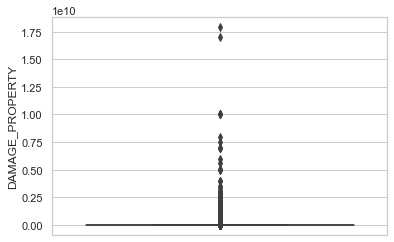

In [17]:
# look for outliers with a boxplot
sns.boxplot( y=df["DAMAGE_PROPERTY"] );
plt.show()

In [18]:
df["DAMAGE_PROPERTY"].value_counts()

0.0              1208379
5,000.0            44298
1,000.0            42880
10,000.0           37586
2,000.0            30523
                  ...   
124,000,000.0          1
1,710,000.0            1
3,850.0                1
81,000,000.0           1
322,200.0              1
Name: DAMAGE_PROPERTY, Length: 2060, dtype: int64

In [19]:
1208379/1558288

0.7754529329623279

The dataset also contains a huge number of storms that did not have any property damage - 78% of observations do not have any damage.
The high number of outliers and high number of zeros make this a fairly irregular dataset.

#### Plot with logarithmic scale

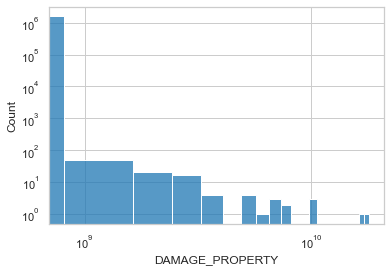

In [20]:
sns.histplot(df['DAMAGE_PROPERTY'])
plt.xscale("log")
plt.yscale("log")

#### Let's look at top states by damange

''

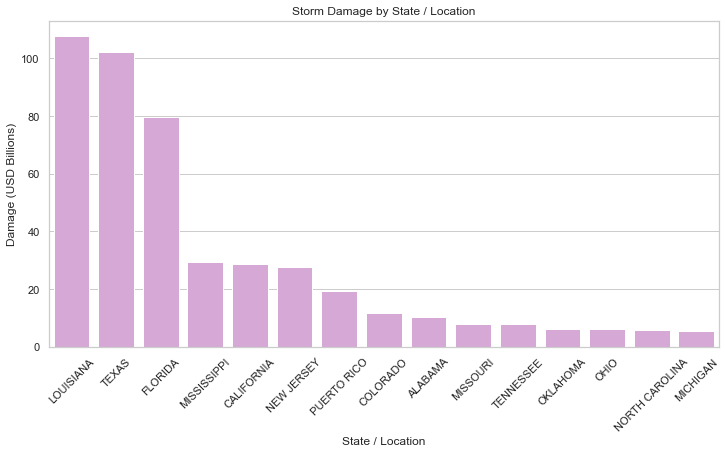

In [21]:

df_states = pd.DataFrame(df.groupby('STATE')['DAMAGE_PROPERTY'].sum().sort_values(ascending=False).reset_index()[:15])
df_states['DAMAGE_PROPERTY'] = df_states['DAMAGE_PROPERTY'] / 1000000000
#df_states

fig, ax = plt.subplots(figsize = (12 , 6))

#plt.figure(figsize=(12,6))
plt.title("Storm Damage by State / Location")
sns.barplot(x = 'STATE', y = 'DAMAGE_PROPERTY', data = df_states,
            color = color_choice1
            )

ax.set_ylabel("Damage (USD Billions)" , size = 12 )
ax.set_xlabel( "State / Location" , size = 12 )
#plt.xticks(rotation=90)
plt.xticks(rotation=45)
;


#### Let's look at damage by storm type

''

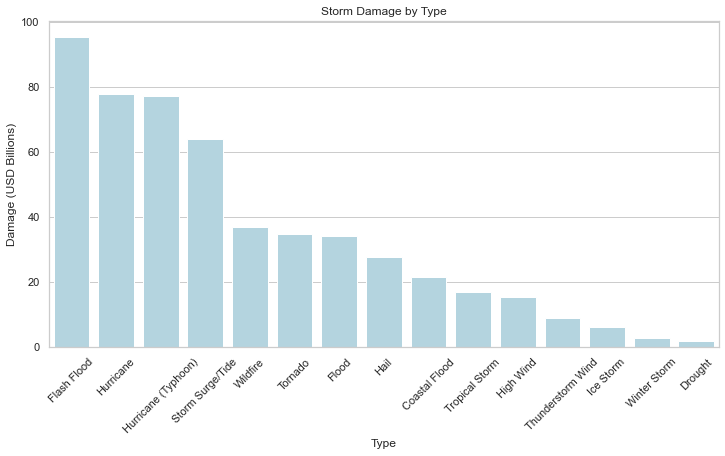

In [22]:
df_event = pd.DataFrame(df.groupby('EVENT_TYPE')['DAMAGE_PROPERTY'].sum().sort_values(ascending=False).reset_index()[:15])
df_event['DAMAGE_PROPERTY'] = df_event['DAMAGE_PROPERTY'] / 1000000000
#df_event

fig, ax = plt.subplots(figsize = (12 , 6))

#plt.figure(figsize=(12,6))
plt.title("Storm Damage by Type")
sns.barplot(x = 'EVENT_TYPE', y = 'DAMAGE_PROPERTY', data = df_event,
            color = color_choice2
            )

ax.set_ylabel("Damage (USD Billions)" , size = 12 )
ax.set_xlabel( "Type" , size = 12 )
plt.xticks(rotation=45)
;


<AxesSubplot:ylabel='Density'>

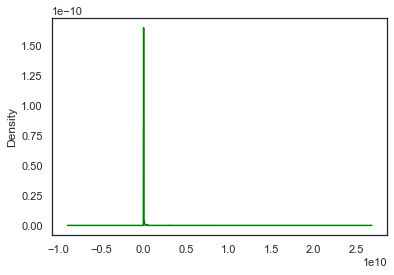

In [47]:
df.DAMAGE_PROPERTY.plot.density(color='green')


<AxesSubplot:ylabel='Density'>

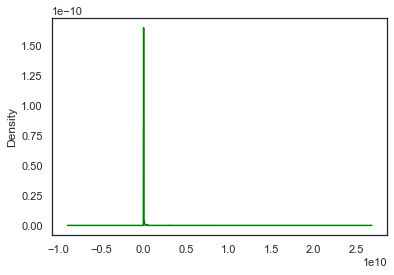

In [49]:
df.DAMAGE_PROPERTY.plot.kde(color='green')

In [46]:
# #sns.kdeplot(data=df_event, x="DAMAGE_PROPERTY", hue="EVENT_TYPE")
# sns.kdeplot(data=df_event, x='DAMAGE_PROPERTY', hue="EVENT_TYPE", multiple="stack")


In [45]:
# df_events2 = df[['EVENT_TYPE', 'DAMAGE_PROPERTY']]
# df_events2

# sns.kdeplot(data=df_events2)
# #sns.kdeplot(data=df_events2, x='DAMAGE_PROPERTY', hue="EVENT_TYPE", multiple="stack")

#### Look at distribution of storm beginning time

''

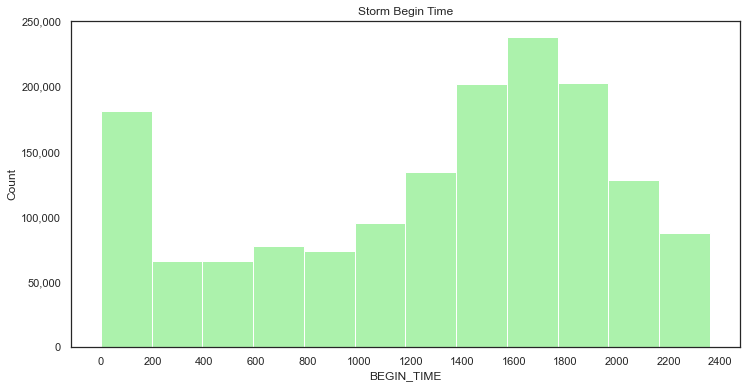

In [24]:
sns.set_style("white")
fig, ax = plt.subplots(figsize = (12 , 6))
plt.title("Storm Begin Time")
sns.histplot(x='BEGIN_TIME', data=df, color=color_choice3, bins=12)
#plt.xticks(rotation=45)
ax.yaxis.set_major_formatter('{x:,.0f}')
plt.xticks(np.arange(0, 2400+100, 200))
;

### Comments
- The high number of storms between midnight and 2AM could be a reporting peculiarlity.
- Interestingly, there is a significant concentration of storms beginning in the early and mid-afternoon

''

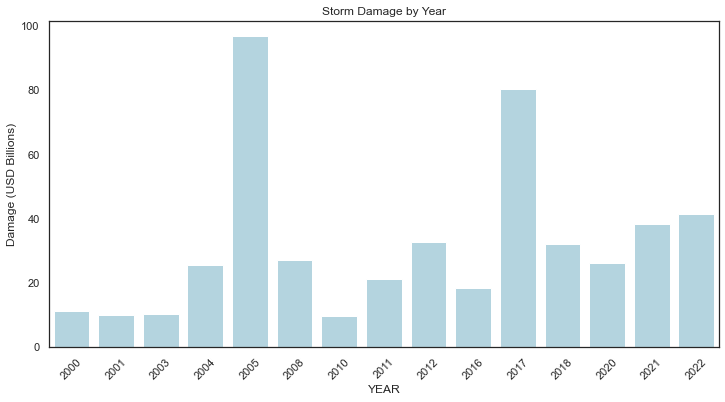

In [25]:
df_damage_year = pd.DataFrame(df.groupby('YEAR')['DAMAGE_PROPERTY'].sum().sort_values(ascending=False).reset_index()[:15])
df_damage_year['DAMAGE_PROPERTY'] = df_damage_year['DAMAGE_PROPERTY'] / 1000000000
#df_event

fig, ax = plt.subplots(figsize = (12 , 6))

#plt.figure(figsize=(12,6))
plt.title("Storm Damage by Year")
sns.barplot(x = 'YEAR', y = 'DAMAGE_PROPERTY', data = df_damage_year,
            color = color_choice2
            )

ax.set_ylabel("Damage (USD Billions)" , size = 12 )
ax.set_xlabel( "YEAR" , size = 12 )
plt.xticks(rotation=45)
;

### Now let's take a look at correlations between variables

In [26]:
df.corr()

,BEGIN_YEARMONTH,BEGIN_TIME,YEAR,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,MAGNITUDE,TOR_LENGTH,TOR_WIDTH,BEGIN_LAT,BEGIN_LON,DURATION,STORM_AREA,PopDensity,Population,HPI
BEGIN_YEARMONTH,1.0,-0.03919869980561563,0.9999904744095054,-0.00617271092384087,0.000253277086235931,0.00020800536807874482,0.014605457689619517,0.0007485229771306517,0.07923245782765753,0.0016456655712361347,0.013920528143037849,-0.026934813844558016,0.05449101600395935,0.0332511912554923,0.011643289596882827,0.01724681217376169,0.03629664033142333,0.27449402666133793
BEGIN_TIME,-0.03919869980561563,1.0,-0.03917502830685883,0.00028892109324939386,-0.0018794515310195672,-0.0022479771033221433,-0.009798339594095928,-0.001636156709438443,0.14996882184006385,0.026146300169729395,0.030889970943824476,0.04294250605868133,-0.00536192662555944,-0.4314204460825511,-0.07357030427380318,-0.0058100835076368715,0.010739740352523501,-0.009145318320139467
YEAR,0.9999904744095054,-0.03917502830685883,1.0,-0.006181041181863849,0.00025287823996559004,0.00019571939893595368,0.014592367154060386,0.0007214805422359039,0.07901380903514775,0.0016632550906894082,0.013961983098446994,-0.027286073731696607,0.05442129735692803,0.03297235361138792,0.011642141631919338,0.01722358698485873,0.036175983673924425,0.274329855560778
INJURIES_DIRECT,-0.00617271092384087,0.00028892109324939386,-0.006181041181863849,1.0,0.005075219075305023,0.1758708672789883,0.059966736691813474,0.08196163238269819,-0.006664676452376176,0.10305654884198076,0.1343185031055749,-0.006077092665655047,0.001566546358710834,0.001497008103788754,0.027003056153938942,0.000794310755867278,0.00447842424635394,-0.0007941407456262684
INJURIES_INDIRECT,0.000253277086235931,-0.0018794515310195672,0.00025287823996559004,0.005075219075305023,1.0,0.0006674088415945876,0.12319414221455606,0.04674927491467155,-0.002043516692873005,0.00036020882524502205,0.0006260059156300709,-0.002308052635502891,-0.002243616058827947,-0.0003182162697480724,0.004174651101233805,-0.00010983966801802125,3.5655251212807904e-05,0.0008175662375545093
DEATHS_DIRECT,0.00020800536807874482,-0.0022479771033221433,0.00019571939893595368,0.1758708672789883,0.0006674088415945876,1.0,0.05568920980392888,0.21663225004278044,-0.007144117238668074,0.029284712569275836,0.04320085651368691,-0.009649083766465541,0.00014580643259647547,-0.0005606072407168083,0.02881487064070151,0.0025815041998478424,0.00824234751903624,0.004886973085027932
DEATHS_INDIRECT,0.014605457689619517,-0.009798339594095928,0.014592367154060386,0.059966736691813474,0.12319414221455606,0.05568920980392888,1.0,0.06304871954325235,-0.013641865871431598,0.004563293398818144,0.006420763679547456,-0.003431866728437854,-0.0037480529844389557,-0.00335453030481138,0.01860617542189843,0.0028600320522594487,0.0032216253608035243,0.0061491137291117956
DAMAGE_PROPERTY,0.0007485229771306517,-0.001636156709438443,0.0007214805422359039,0.08196163238269819,0.04674927491467155,0.21663225004278044,0.06304871954325235,1.0,-0.004670442229409922,0.009342790992440085,0.014040001633286853,-0.009826840945699999,-0.0002394579521008737,0.0010100041924322508,0.02259456686132373,0.002483530457335198,0.00958714969484498,0.0025556075351823686
MAGNITUDE,0.07923245782765753,0.14996882184006385,0.07901380903514775,-0.006664676452376176,-0.002043516692873005,-0.007144117238668074,-0.013641865871431598,-0.004670442229409922,1.0,-0.03976580126778751,-0.04408207953920891,0.01843746008421094,0.18321542761169723,-0.15000378957208402,-0.09283522504553512,-0.005813586185724675,0.0030076951236850183,0.007053578872191981
TOR_LENGTH,0.0016456655712361347,0.026146300169729395,0.0016632550906894082,0.10305654884198076,0.00036020882524502205,0.029284712569275836,0.004563293398818144,0.009342790992440085,-0.03976580126778751,1.0,0.5238966821520907,-0.020744360771925145,-0.006176838401550505,-0.019902398692552243,0.12465234258124264,-0.007900664324403553,-0.013466771498288106,-0.020312207274804293


In [27]:
# set up dataframe for correlation matrix
df_corr = df[['INJURIES_DIRECT', 'INJURIES_INDIRECT','DEATHS_DIRECT', 'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'MAGNITUDE', 'TOR_LENGTH', 'TOR_WIDTH', 'BEGIN_LAT','BEGIN_LON', 'DURATION', 'STORM_AREA', 'PopDensity', 'Population', 'HPI']]

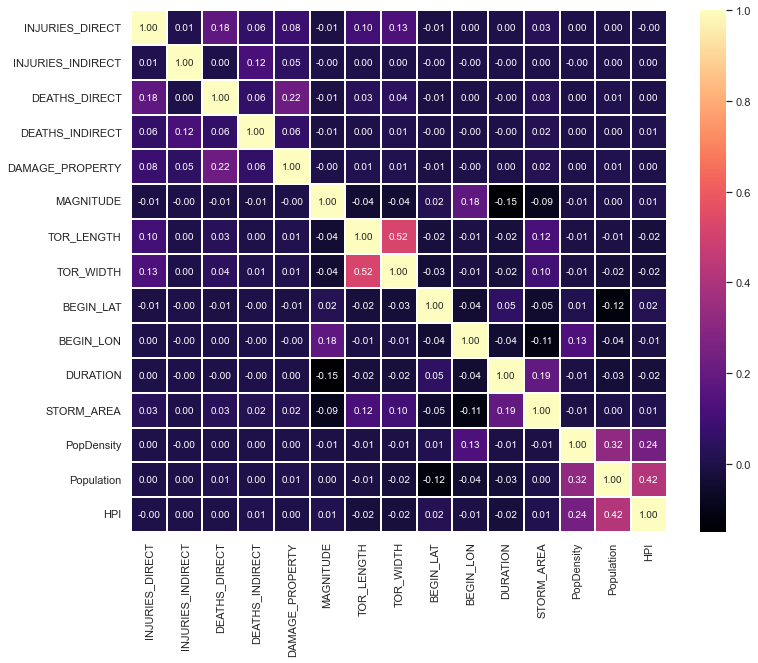

In [28]:
corrmat = df_corr.corr()
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(round(corrmat,2), annot=True, ax=ax, cmap='magma',fmt='.2f',
                 linewidths=.05)

f.subplots_adjust(top=0.93)

### Comments:
- there aren't any strong correlations with the dependent variable.  I'll try removing some of the extreme values

In [29]:
# sort values by higest to lowest to remove some of the outliers
df2 = df.sort_values('DAMAGE_PROPERTY', ascending=False)

In [30]:
# remove top 10,000 values
df2 = df2[10000:]

In [31]:
# remove all obserations with zero property damage
df2 = df2[df2['DAMAGE_PROPERTY'] > 0]

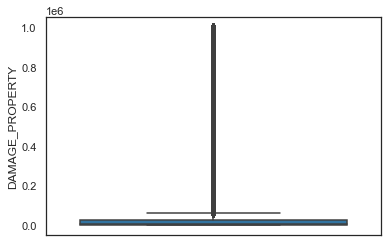

In [32]:
sns.boxplot( y=df2["DAMAGE_PROPERTY"] );
plt.show()

#### This improved the boxplot somewhat, although it is still certainly not a normal distrubtion 

In [33]:
df_corr2 = df2[['INJURIES_DIRECT', 'INJURIES_INDIRECT','DEATHS_DIRECT', 'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'MAGNITUDE', 'TOR_LENGTH', 'TOR_WIDTH', 'BEGIN_LAT','BEGIN_LON', 'DURATION', 'STORM_AREA', 'PopDensity', 'Population', 'HPI']]

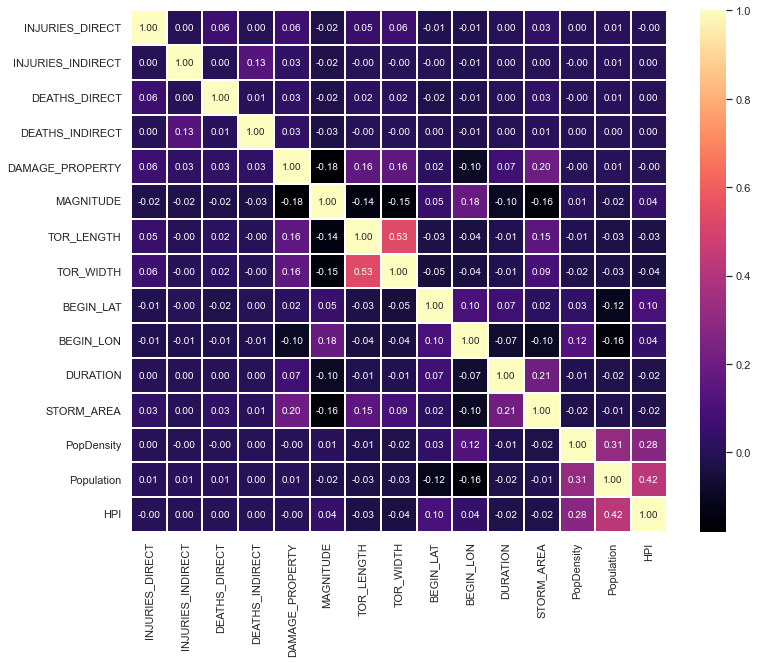

In [34]:
corrmat = df_corr2.corr()
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(round(corrmat,2), annot=True, ax=ax, cmap='magma',fmt='.2f',
                 linewidths=.05)

f.subplots_adjust(top=0.93)

### Comments:
- This did appear to improve the correlation of some variables with property damage

#### For fun, create a word cloud of episode narrative

In [35]:
### word cloud
# df['EPISODE_NARRATIVE'] = df['EPISODE_NARRATIVE'].astype('str')
# title_corpus = ' '.join(df['EPISODE_NARRATIVE'])
# title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
# plt.figure(figsize=(16,8))
# plt.imshow(title_wordcloud)
# plt.axis('off')
# plt.show()

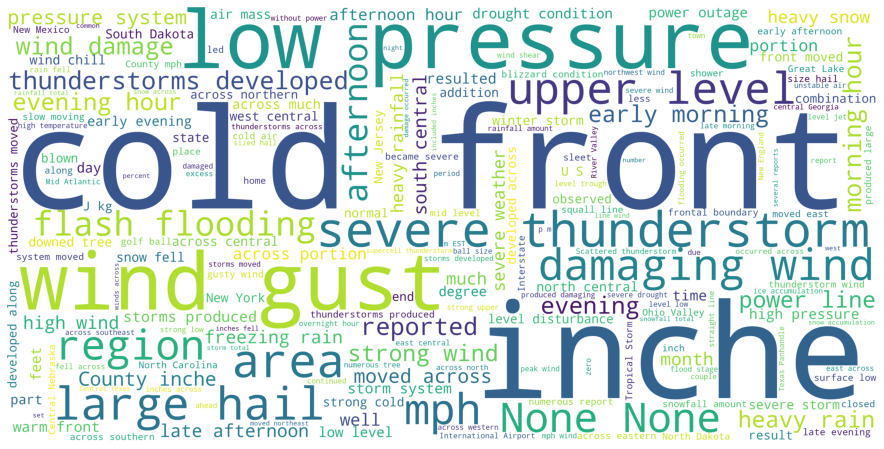

scratch notes

In [36]:
# do a log norm of this plot
# try doing KDE
# try Light GBM and XGBoost
# tweedie distribution -